In [1]:
import sklearn
from sklearn import datasets
import numpy as np
from matplotlib import pyplot as plt
from distances import euclidean_distance, cosine_distance
from nearest_neighbors import KNNClassifier
from cross_validation import kfold, knn_cross_val_score

import seaborn as sns

plt.style.use('dark_background')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Preparations

In [2]:
Data = sklearn.datasets.fetch_openml("mnist_784")

In [3]:
X = Data["data"].to_numpy()
y = Data["target"].to_numpy()

In [92]:
X.shape, y.shape

((70000, 784), (70000,))

In [93]:
conc = np.concatenate((X, Y.reshape(-1, 1)), axis=1)
np.save("./Data/mnist.npy", conc)

NameError: name 'Y' is not defined

5


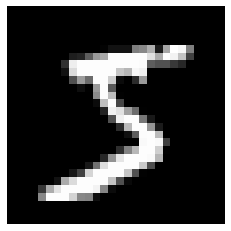

In [55]:
i = 0
plt.imshow(X[i].reshape(28, 28), cmap="gray")
plt.axis("off")
print(Y[i])

In [228]:
train = 60_000
test = len(X) - train
X_train, y_train = X[:train], y[:train]
X_test, y_test = X[train:], y[train:]

In [229]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

# Experiment 1

In [230]:
from time import time as time

In [91]:
28*28

784

In [94]:
def find_nearest(X_train, y_train, X_test, search_zone=10, checkpoint=2500, **kwargs):
    X_train, X_test = X_train[:, :search_zone], X_test[:, :search_zone]
    clf = KNNClassifier(**kwargs)
    clf.fit(X_train, y_train)
    
    timelist = list()
    for i, elem in enumerate(X_test):
        if not (i % checkpoint):
            print(f"{i}/{len(X_test)}")
        start = time()
        clf.find_kneighbors(elem.reshape(1, -1))
        timelist.append(time() - start)
        
    return timelist

In [109]:
# my own
my_own = list()
for search_R in (250,):
    my_own.append(find_nearest(X_train, y_train, X_test, search_R, k=5, strategy="my_own", metric="euclidean", weights=False))

0/10000
2500/10000
5000/10000
7500/10000


In [115]:
# kd_tree
kd_tree = list()
for search_R in (250,):
    kd_tree.append(find_nearest(X_train, y_train, X_test, search_R, k=5, strategy="kd_tree", metric="euclidean", weights=False))

0/10000
2500/10000
5000/10000
7500/10000


In [111]:
# ball_tree
ball_tree = list()
for search_R in (250,):
    ball_tree.append(find_nearest(X_train, y_train, X_test, search_R, k=5, strategy="ball_tree", metric="euclidean", weights=False))

0/10000
2500/10000
5000/10000
7500/10000


In [116]:
# brute
brute = list()
for search_R in (250,):
    brute.append(find_nearest(X_train, y_train, X_test, search_R, k=5, strategy="brute", metric="euclidean", weights=False))

0/10000
2500/10000
5000/10000
7500/10000


In [117]:
times = (kd_tree, brute)
new = [elem[0] for elem in times]

In [118]:
for i, method in enumerate(("kd_tree", "brute")):
    for zone_size, times in zip((750, ), (new, )):
        print(f"method={method}, zone_size={zone_size}, mean={np.mean(times[i])}")

method=kd_tree, zone_size=750, mean=0.049037406277656556
method=brute, zone_size=750, mean=0.035906098294258115


In [108]:
for i, method in enumerate(("my_own", "kd_tree", "ball_tree", "brute")):
    for zone_size, times in zip((10, 20, 100), (tens, twenties, hundreds)):
        print(f"method={method}, zone_size={zone_size}, mean={round(np.mean(times[i]), 5)}")

method=my_own, zone_size=10, mean=0.00205
method=my_own, zone_size=20, mean=0.0034
method=my_own, zone_size=100, mean=0.01246
method=kd_tree, zone_size=10, mean=0.00133
method=kd_tree, zone_size=20, mean=0.00208
method=kd_tree, zone_size=100, mean=0.00742
method=ball_tree, zone_size=10, mean=0.00119
method=ball_tree, zone_size=20, mean=0.00165
method=ball_tree, zone_size=100, mean=0.00637
method=brute, zone_size=10, mean=0.00124
method=brute, zone_size=20, mean=0.00114
method=brute, zone_size=100, mean=0.00486


# Experiment 2

In [226]:
# Two barplots in one?
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 250]

In [231]:
euclidean = knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, k=1, strategy="my_own", metric="euclidean", weights=False)

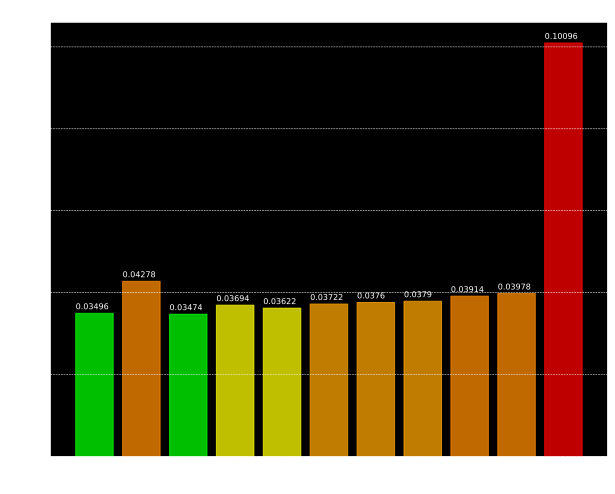

In [294]:
def bar_color(val):
    if val <= 0.035:
        return "lime"
    elif 0.035 < val <= 0.037:
        return "yellow"
    elif 0.037 <= val < 0.039:
        return "orange"
    elif val < 0.05:
        return "darkorange"
    else:
        return "red"

test = list()
for val in euclidean.values():
    test.append(np.mean(val))
    
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Доля неверно предсказанных классов в зависимости от $k$, евклидова метрика")
ax.set_xlabel("k, число соседей в алгоритме")
ax.set_ylabel("Доля неверных предсказаний")

labels = k_list[:-1] + [250]
ax.set_xticks(k_list[:-1] + [11], labels)
ax.bar(k_list[:-1] + [11], 1 - np.array(test))
ax.grid(axis="y", linestyle = '--', linewidth = 0.5)

for p in ax.patches:
    ax.annotate(
        str(round(float(p.get_height()), 5)), (p.get_x(), p.get_height() + 0.001),
        fontsize=8
    )
    p.set(color=bar_color(p.get_height()), alpha=0.75)

fig.savefig("../pyhometask/s4/pictures/Euclidean.pdf")

In [232]:
cos = knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, strategy="my_own", metric="cosine", weights=False)

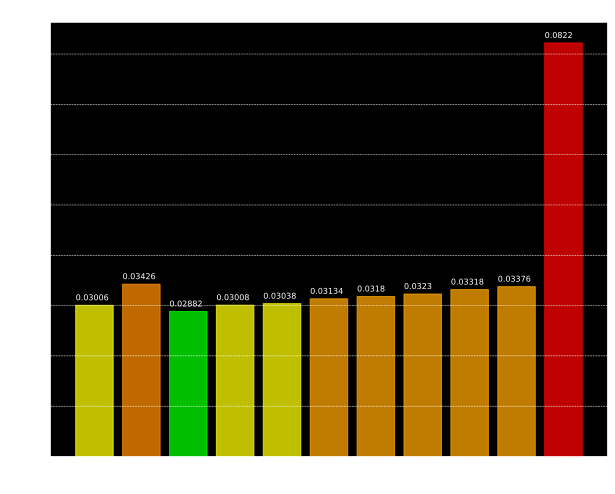

In [293]:
def bar_color(val):
    if val <= 0.03:
        return "lime"
    elif 0.03 < val <= 0.0313:
        return "yellow"
    elif 0.0313 <= val < 0.034:
        return "orange"
    elif val < 0.05:
        return "darkorange"
    else:
        return "red"

test = list()
for val in cos.values():
    test.append(np.mean(val))
    
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Доля неверно предсказанных классов в зависимости от $k$, косинусное расстояние")
ax.set_xlabel("k, число соседей в алгоритме")
ax.set_ylabel("Доля неверных предсказаний")

labels = k_list[:-1] + [250]
ax.set_xticks(k_list[:-1] + [11], labels)
ax.bar(k_list[:-1] + [11], 1 - np.array(test))
ax.grid(axis="y", linestyle = '--', linewidth = 0.5)

for p in ax.patches:
    ax.annotate(
        str(round(float(p.get_height()), 5)), (p.get_x(), p.get_height() + 0.001),
        fontsize=8
    )
    p.set(color=bar_color(p.get_height()), alpha=0.75)

fig.savefig("../pyhometask/s4/pictures/Cosine.pdf")

In [237]:
delta = np.array(list(cos.values())) - np.array(list(euclidean.values()))

In [238]:
delta = np.mean(delta, axis=1)

In [239]:
delta.shape

(11,)

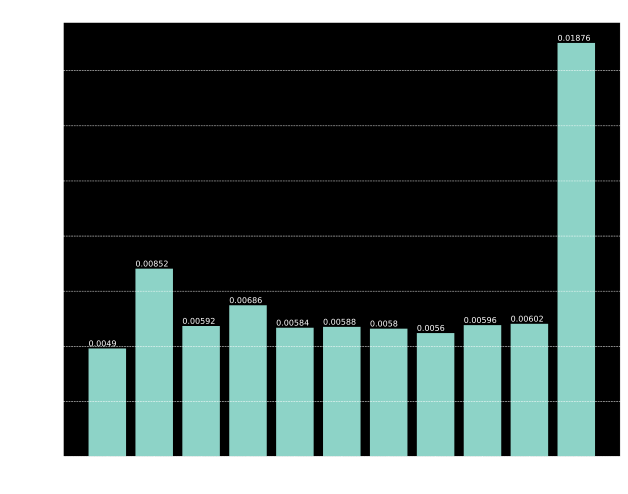

In [295]:
test = delta
    
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("accuracy(cosine) - accuracy(euclidean)")
ax.set_xlabel("k, число соседей в алгоритме")
ax.set_ylabel("Разность в доле верно предсказанных ответов")

labels = k_list[:-1] + [250]
ax.set_xticks(k_list[:-1] + [11], labels)
ax.bar(k_list[:-1] + [11], np.array(test))
ax.grid(axis="y", linestyle = '--', linewidth = 0.5)

for p in ax.patches:
    ax.annotate(
        str(round(float(p.get_height()), 5)), (p.get_x(), p.get_height() + 0.0001),
        fontsize=8
    )

fig.savefig("../pyhometask/s4/pictures/Delta.pdf")

In [219]:
X1 = X[0].copy()
X1[X1>0] = 255
X2 = X1.copy()
X2[X2 > 0] = 1
mask = (X2 > 0) * np.random.randint(0, 20, (784, ))
X2 = X2 * mask
X3 = X[45]

In [220]:
X_arr = np.array((
            X1.reshape(-1),
            X2.reshape(-1),
            X3.reshape(-1),
        ))
X_arr.shape

(3, 784)

In [221]:
euclidean_distance(X_arr, X_arr)

array([[0.00000000e+00, 3.16011804e+03, 3.13893931e+03],
       [3.16011804e+03, 0.00000000e+00, 2.22537772e+03],
       [3.13893931e+03, 2.22537772e+03, 4.31583729e-05]])

In [222]:
cosine_distance(X_arr, X_arr)

array([[0.00000000e+00, 1.38426928e-01, 5.90545674e-01],
       [1.38426928e-01, 0.00000000e+00, 6.18397793e-01],
       [5.90545674e-01, 6.18397793e-01, 2.22044605e-16]])

In [223]:
X2 = 255 - X2

In [224]:
X_app = np.concatenate(
        (
            X1.reshape(28, 28),
            X2.reshape(28, 28),
            X3.reshape(28, 28),
        ),
    axis=1
)

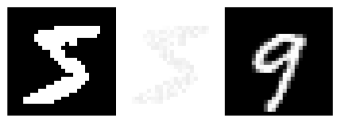

In [247]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(X_app, cmap="gray")
ax.axis("off")

fig.savefig("../pyhometask/s4/pictures/EuclideanVSCosine.pdf")

# Experiment 3

In [256]:
no_weights = knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, strategy="my_own", metric="cosine", weights=False)

In [257]:
weights = knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, strategy="my_own", metric="cosine", weights=True)

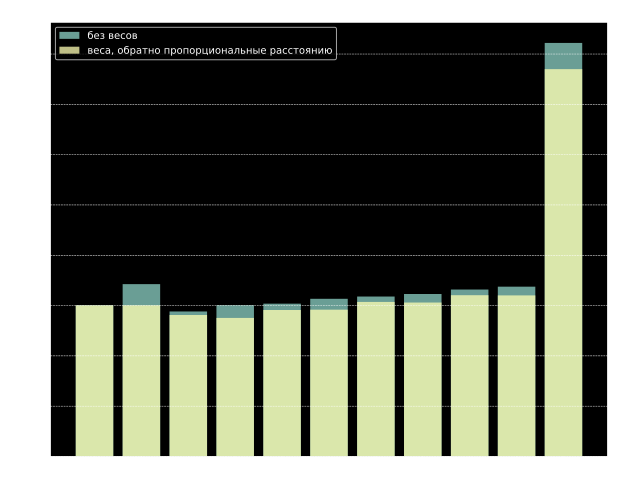

In [296]:
test1 = list()
for val in no_weights.values():
    test1.append(np.mean(val))
    
test2 = list()
for val in weights.values():
    test2.append(np.mean(val))
    
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Доля неверных предсказаний в зависимости от $k$ для взвешенного и простого алгоритмов")
ax.set_xlabel("$k$, число соседей в алгоритме")
ax.set_ylabel("Доля неверных предсказаний")

labels = k_list[:-1] + [250]
ax.set_xticks(k_list[:-1] + [11], labels)
ax.grid(axis="y", linestyle = '--', linewidth = 0.5)
ax.bar(k_list[:-1] + [11], 1 - np.array(test1), alpha=0.75, label="без весов")
ax.bar(k_list[:-1] + [11], 1 - np.array(test2), alpha=0.75, label="веса, обратно пропорциональные расстоянию")

ax.legend()

fig.savefig("../pyhometask/s4/pictures/Weights.pdf")

# Experiment 4

In [616]:
clf = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True)

In [654]:
clf.fit(X_train, y_train)

In [655]:
preds = clf.predict(X_test)

In [314]:
np.count_nonzero(preds == y_test) / len(y_test)

0.9752

In [307]:
preds = clf.predict(X_train)

In [308]:
np.count_nonzero(preds == y_train) / len(y_train)

1.0

In [309]:
preds = knn_cross_val_score(X, y, [4], score='accuracy', cv=None, strategy="brute", metric="cosine", weights=True)

In [310]:
preds

{4: array([0.97366053, 0.97174057, 0.97131885])}

In [315]:
# Confusion matrices

In [656]:
confusion = sklearn.metrics.confusion_matrix(y_test, preds)

In [657]:
confusion

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

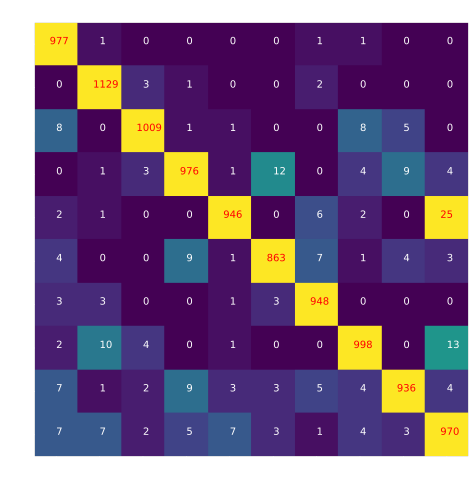

In [622]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Матрица ошибок лучшего классификатора")
ax.set_xlabel("Предсказанные значения")
ax.set_ylabel("Правильные ответы")
ax.set_xticks(range(10))
ax.set_yticks(range(10))

Il = np.eye(10) * np.diag(confusion)

M = confusion - Il
M = M + np.eye(10)*25
ax.imshow(M)
for i in range(10):
    for j in range(10):
        if (j==4) and (i==9) or (i == j):
            ax.text(i - 0.15, j, str(int(confusion.T[i][j])), color="red")
        else:
            ax.text(i, j, str(int(M.T[i][j])))
            
fig.savefig("../pyhometask/s4/pictures/Confusion.pdf")

In [362]:
bad = np.where(preds != y_test)[0]

(array([ 115,  241,  247,  320,  321,  358,  444,  445,  447,  448,  464,
         495,  551,  582,  591,  628,  707,  740,  839,  881,  924,  938,
         939,  947,  951,  956,  957, 1014, 1062, 1089, 1107, 1112, 1114,
        1178, 1192, 1226, 1232, 1242, 1247, 1260, 1290, 1299, 1319, 1325,
        1393, 1422, 1425, 1494, 1500, 1522, 1530, 1549, 1553, 1559, 1681,
        1695, 1721, 1737, 1778, 1790, 1865, 1878, 1901, 1955, 1970, 1984,
        2044, 2052, 2093, 2098, 2105, 2109, 2118, 2129, 2130, 2135, 2182,
        2224, 2237, 2266, 2272, 2293, 2298, 2299, 2339, 2387, 2395, 2406,
        2408, 2447, 2454, 2488, 2533, 2607, 2648, 2654, 2721, 2758, 2771,
        2810, 2863, 2896, 2901, 2927, 2939, 2952, 2953, 3005, 3062, 3073,
        3117, 3333, 3336, 3369, 3405, 3475, 3490, 3503, 3520, 3549, 3558,
        3559, 3597, 3629, 3702, 3780, 3796, 3808, 3811, 3838, 3853, 3893,
        3902, 3926, 3941, 3976, 3985, 4007, 4017, 4075, 4078, 4145, 4163,
        4176, 4194, 4199, 4212, 4224, 

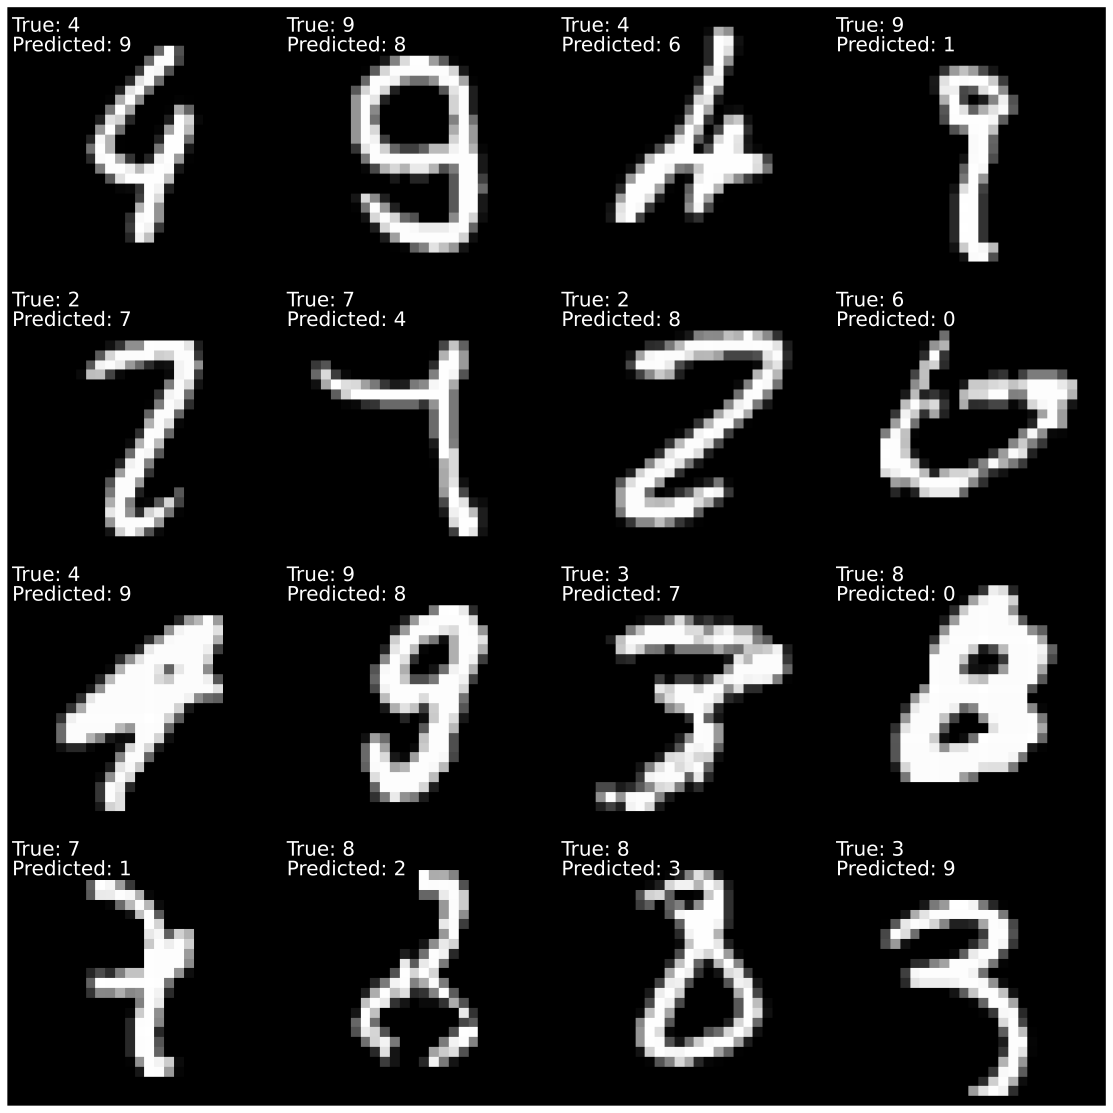

In [417]:
fig, ax = plt.subplots(figsize=(16, 16))
fig.tight_layout()

img = np.empty((0, 28*4))
for i in range(4):
    row = np.empty((28, 0))
    for j in range(4):
        idx = bad[4*i + j]
        image = X_test[idx].reshape(28, 28)
        row = np.concatenate((row, image), axis=1)
        ax.text(j*28, (i*28) + 2, f"True: {y_test[idx]}", fontsize=20)
        ax.text(j*28, (i*28) + 4, f"Predicted: {preds[idx]}", fontsize=20)
    img = np.concatenate((img, row), axis=0)

ax.axis("off")
ax.imshow(img, cmap="gray")

fig.savefig("../pyhometask/s4/pictures/WrongExamples.pdf")

# Experiment 5

In [579]:
import skimage.io
import skimage.color
import skimage.transform
import scipy.ndimage
import cv2 as cv
import PIL

from random import randint as randint

In [582]:
def rotate(img, angle=0):
    if randint(0, 1):
        angle = -angle
    return skimage.transform.rotate(img, angle)

def shift(img, t):
    v, h = t
    if randint(0, 1):
        v = -v
    if randint(0, 1):
        h = -h
    return scipy.ndimage.shift(img, [v, h])

def blur(img, sigma=0, kernel_size=15):
    return cv.GaussianBlur(img, (kernel_size, kernel_size), sigma)

def erosion(img, p):
    kernel = np.ones((p, p),np.uint8)
    return cv.erode(img, kernel, iterations = 1)

def dilation(img, p):
    kernel = np.ones((p, p),np.uint8)
    return cv.dilate(img, kernel, iterations = 1)

def opening(img, p):
    kernel = np.ones((p, p),np.uint8)
    return cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

def closing(img, p):
    kernel = np.ones((p, p),np.uint8)
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

In [435]:
test = X[2].copy().reshape(28, 28)

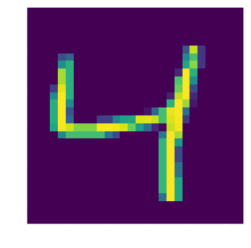

In [436]:
plt.imshow(test)

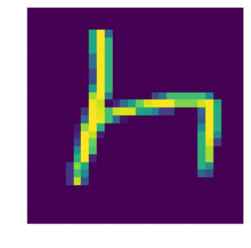

In [571]:
plt.imshow(rotate(test, 180))

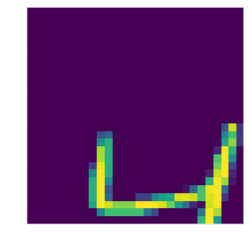

In [574]:
plt.imshow(shift(test, (10, -5)))

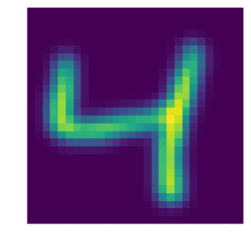

In [501]:
plt.imshow(blur(test, 1, 15))

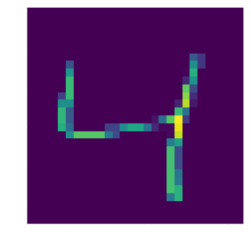

In [583]:
plt.imshow(erosion(test, 2))

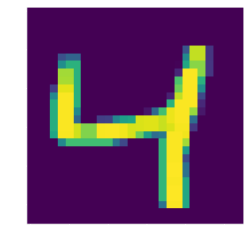

In [584]:
plt.imshow(dilation(test, 2))

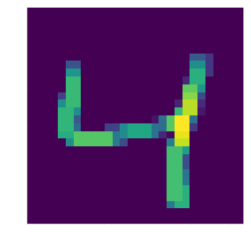

In [585]:
plt.imshow(opening(test, 2))

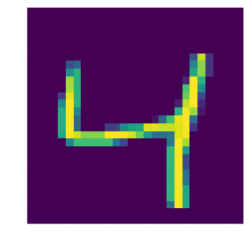

In [586]:
plt.imshow(closing(test, 2))

In [608]:
def greedy(clf, X_train, y_train, X_test, y_test, transforms, n=20_000):
    confusions = list()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.count_nonzero(preds == y_test) / len(y_test)
    print(f"Hit accuracy {accuracy} with no transforms")
    
    X_orig = X_train.copy()
    y_orig = y_train.copy()
    best_X = X_orig
    best_y = y_orig
    for t in transforms:
        transform, parameters = t
        print(f"\nChecking {t[0].__name__}...")
        for p in parameters:
            print(f"Checking parameter {p}...")
            ind = np.random.randint(0, len(y_orig), n)
            Xa = X_orig[ind].copy()
            ya = y_orig[ind].copy()
            aug = list()
            for i in range(len(Xa)):
                aug.append(transform(Xa[i].reshape(28, 28), p).reshape(-1))
            aug = np.array(aug)
            Xa = np.concatenate((X_orig, aug), axis=0)
            ya = np.concatenate((y_orig, ya))
            
            clf.fit(Xa, ya)
            preds = clf.predict(X_test)
            new_accuracy = np.count_nonzero(preds == y_test) / len(y_test)
            if new_accuracy > accuracy:
                print(f"Hit accuracy {new_accuracy} with transform={transform.__name__}, p={p}")
                accuracy = new_accuracy
                confusions.append(sklearn.metrics.confusion_matrix(y_test, preds))
                best_X = Xa
                best_y = ya
            else:
                print(f"Transform {transform.__name__}, p={p} lost with {new_accuracy}")
        X_orig = best_X
        y_orig = best_y
    return confusions

In [609]:
shifts_tuple = (
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (2, 2),
    (2, 3),
    (3, 1),
    (3, 2),
    (3, 3)
)

transforms = [
    (rotate, (5, 10, 15)),
    (shift, shifts_tuple),
    (blur, (0.5, 1.0, 1.5)),
    (erosion, (2,)),
    (dilation, (2,)),
    (opening, (2,)),
    (closing, (2,))
]

In [652]:
clf = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True)

In [611]:
confusions = greedy(clf, X_train, y_train, X_test, y_test, transforms)

Hit accuracy 0.9752 with no transforms

Checking rotate...
Checking parameter 5...
Hit accuracy 0.9753 with transform=rotate, p=5
Checking parameter 10...
Hit accuracy 0.9768 with transform=rotate, p=10
Checking parameter 15...
Transform rotate, p=15 lost with 0.9768

Checking shift...
Checking parameter (1, 1)...
Hit accuracy 0.9774 with transform=shift, p=(1, 1)
Checking parameter (1, 2)...
Transform shift, p=(1, 2) lost with 0.9771
Checking parameter (1, 3)...
Transform shift, p=(1, 3) lost with 0.9769
Checking parameter (2, 1)...
Transform shift, p=(2, 1) lost with 0.9773
Checking parameter (2, 2)...
Transform shift, p=(2, 2) lost with 0.9767
Checking parameter (2, 3)...
Transform shift, p=(2, 3) lost with 0.9768
Checking parameter (3, 1)...
Transform shift, p=(3, 1) lost with 0.9771
Checking parameter (3, 2)...
Transform shift, p=(3, 2) lost with 0.9768
Checking parameter (3, 3)...
Transform shift, p=(3, 3) lost with 0.9768

Checking blur...
Checking parameter 0.5...
Transform blu

In [612]:
# 1 2 4 8(all)
rotate_confusion = confusions[1]
shift_confusion = confusions[2]
blur_confusion = confusions[4]
morph_confusion = confusions[8]

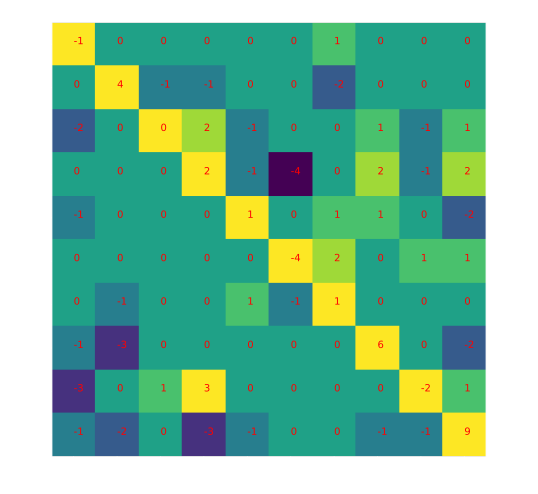

In [634]:
confusion2 = rotate_confusion - confusion

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Разность новой и старой матрицы ошибок (после аугментации поворотами на 15)")
ax.set_xlabel("Предсказанные значения")
ax.set_ylabel("Правильные ответы")
ax.set_xticks(range(10))
ax.set_yticks(range(10))

Il = np.eye(10) * np.diag(confusion2)

M = confusion2 - Il
M = M + np.eye(10) * np.max(M)
ax.imshow(M)
for i in range(10):
    for j in range(10):
        ax.text(i, j, str(int(confusion2.T[i][j])), color="red")
        
fig.savefig("../pyhometask/s4/pictures/ConfusionDifferenceRotate.pdf")

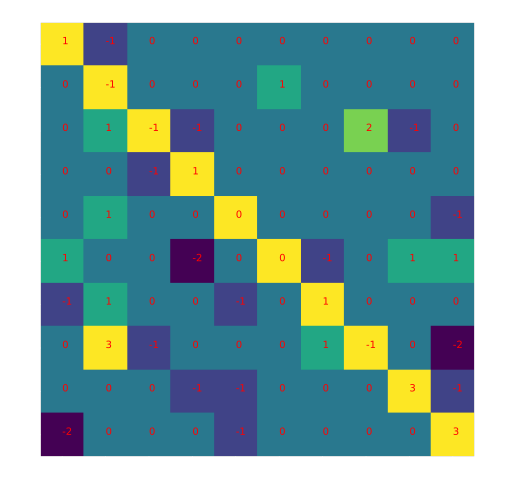

In [637]:
confusion2 = shift_confusion - rotate_confusion

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Разность новой и старой матрицы ошибок (после аугментации сдвигами на 1)")
ax.set_xlabel("Предсказанные значения")
ax.set_ylabel("Правильные ответы")
ax.set_xticks(range(10))
ax.set_yticks(range(10))

Il = np.eye(10) * np.diag(confusion2)

M = confusion2 - Il
M = M + np.eye(10) * np.max(M)
ax.imshow(M)
for i in range(10):
    for j in range(10):
        ax.text(i, j, str(int(confusion2.T[i][j])), color="red")
        
fig.savefig("../pyhometask/s4/pictures/ConfusionDifferenceShift.pdf")

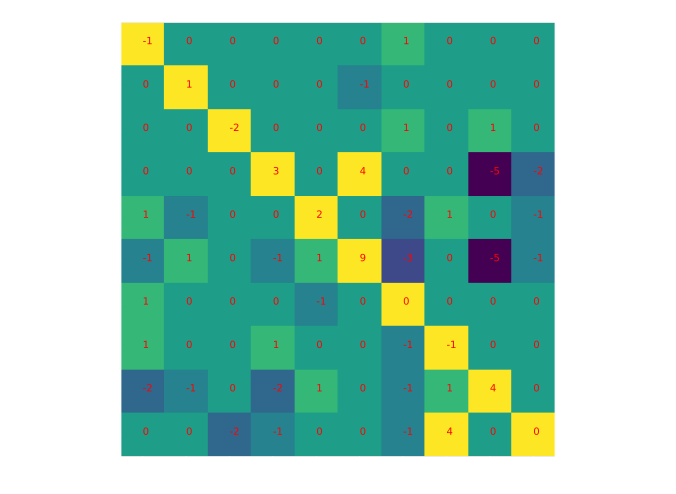

In [640]:
confusion2 = blur_confusion - shift_confusion

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Разность новой и старой матрицы ошибок (после аугментации с гауссовским фильтром дисперсии 1.5)")
ax.set_xlabel("Предсказанные значения")
ax.set_ylabel("Правильные ответы")
ax.set_xticks(range(10))
ax.set_yticks(range(10))

Il = np.eye(10) * np.diag(confusion2)

M = confusion2 - Il
M = M + np.eye(10) * np.max(M)
ax.imshow(M)
for i in range(10):
    for j in range(10):
        ax.text(i, j, str(int(confusion2.T[i][j])), color="red")
        
fig.savefig("../pyhometask/s4/pictures/ConfusionDifferenceBlur.pdf")

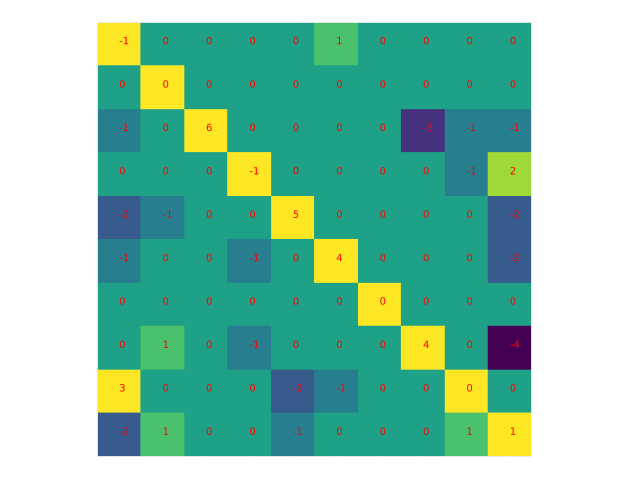

In [641]:
confusion2 = morph_confusion - blur_confusion

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Разность новой и старой матрицы ошибок (после аугментации морфологическими операциями)")
ax.set_xlabel("Предсказанныевв значения")
ax.set_ylabel("Правильные ответы")
ax.set_xticks(range(10))
ax.set_yticks(range(10))

Il = np.eye(10) * np.diag(confusion2)

M = confusion2 - Il
M = M + np.eye(10) * np.max(M)
ax.imshow(M)
for i in range(10):
    for j in range(10):
        ax.text(i, j, str(int(confusion2.T[i][j])), color="red")
        
fig.savefig("../pyhometask/s4/pictures/ConfusionDifferenceMorph.pdf")

# Experiment 6

In [646]:
def greedy(clf, X_train, y_train, X_test, y_test, transforms, n=10_000):
    confusions = list()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.count_nonzero(preds == y_test) / len(y_test)
    print(f"Hit accuracy {accuracy} with no transforms")
    
    X_orig = X_test.copy()
    y_orig = y_test.copy()
    best_X = X_orig
    best_y = y_orig
    for t in transforms:
        transform, parameters = t
        print(f"\nChecking {t[0].__name__}...")
        for p in parameters:
            print(f"Checking parameter {p}...")
            ind = np.random.randint(0, len(y_orig), n)
            Xa = X_orig[ind].copy()
            ya = y_orig[ind].copy()
            aug = list()
            for i in range(len(Xa)):
                aug.append(transform(Xa[i].reshape(28, 28), p).reshape(-1))
            aug = np.array(aug)
            Xa = np.concatenate((X_orig, aug), axis=0)
            ya = np.concatenate((y_orig, ya))
            
            preds = clf.predict(Xa)
            new_accuracy = np.count_nonzero(preds == ya) / len(ya)
            if new_accuracy > accuracy:
                print(f"Hit accuracy {new_accuracy} with transform={transform.__name__}, p={p}")
                accuracy = new_accuracy
                confusions.append(sklearn.metrics.confusion_matrix(ya, preds))
                best_X = Xa
                best_y = ya
            else:
                print(f"Transform {transform.__name__}, p={p} lost with {new_accuracy}")
        X_orig = best_X
        y_orig = best_y
    return confusions

In [647]:
shifts_tuple = (
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (2, 2),
    (2, 3),
    (3, 1),
    (3, 2),
    (3, 3)
)

transforms = [
    (rotate, (5, 10, 15)),
    (shift, shifts_tuple),
    (blur, (0.5, 1.0, 1.5)),
    (erosion, (2,)),
    (dilation, (2,)),
    (opening, (2,)),
    (closing, (2,))
]

In [648]:
clf = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True)

In [649]:
confusions = greedy(clf, X_train, y_train, X_test, y_test, transforms)

Hit accuracy 0.9752 with no transforms

Checking rotate...
Checking parameter 5...
Transform rotate, p=5 lost with 0.97485
Checking parameter 10...
Transform rotate, p=10 lost with 0.9707
Checking parameter 15...
Transform rotate, p=15 lost with 0.9603

Checking shift...
Checking parameter (1, 1)...
Transform shift, p=(1, 1) lost with 0.94405
Checking parameter (1, 2)...
Transform shift, p=(1, 2) lost with 0.85155
Checking parameter (1, 3)...
Transform shift, p=(1, 3) lost with 0.73435
Checking parameter (2, 1)...
Transform shift, p=(2, 1) lost with 0.86195
Checking parameter (2, 2)...
Transform shift, p=(2, 2) lost with 0.77525
Checking parameter (2, 3)...
Transform shift, p=(2, 3) lost with 0.6768
Checking parameter (3, 1)...
Transform shift, p=(3, 1) lost with 0.73815
Checking parameter (3, 2)...
Transform shift, p=(3, 2) lost with 0.676
Checking parameter (3, 3)...
Transform shift, p=(3, 3) lost with 0.616

Checking blur...
Checking parameter 0.5...
Hit accuracy 0.97585 with transf

In [651]:
blur_confusion = confusions[0]

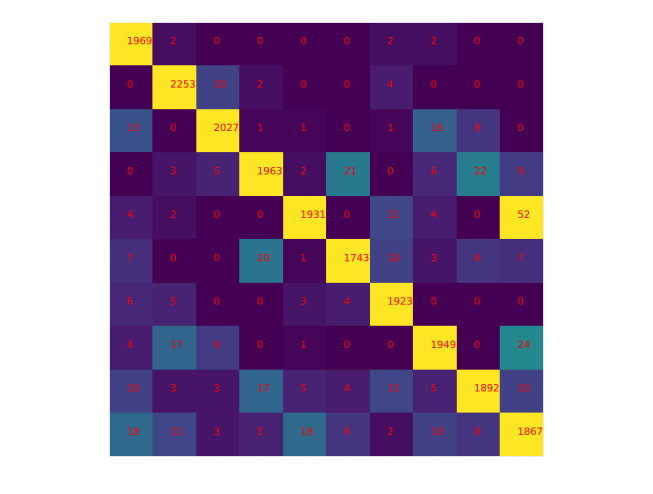

In [662]:
confusion2 = blur_confusion

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Разность новой и старой матрицы ошибок (после аугментации тестовой выборки фильтром Гаусса)")
ax.set_xlabel("Предсказанные значения")
ax.set_ylabel("Правильные ответы")
ax.set_xticks(range(10))
ax.set_yticks(range(10))

Il = np.eye(10) * np.diag(confusion2)

M = confusion2 - Il
M = M + np.eye(10) * np.max(M)
ax.imshow(M)
for i in range(10):
    for j in range(10):
        ax.text(i - 0.1, j, str(int(confusion2.T[i][j])), color="red")
        
fig.savefig("../pyhometask/s4/pictures/ConfusionDifferenceBlur6.pdf")

In [659]:
confusion2

array([[ 992,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1124,    7,    1,    0,    0,    2,    0,    0,    0],
       [   5,    0, 1018,    0,    0,    0,    1,    8,    3,    0],
       [   0,    2,    2,  987,    1,    9,    0,    2,   13,    5],
       [   2,    1,    0,    0,  985,    0,    5,    2,    0,   27],
       [   3,    0,    0,   11,    0,  880,    3,    2,    4,    4],
       [   3,    2,    0,    0,    2,    1,  975,    0,    0,    0],
       [   2,    7,    5,    0,    0,    0,    0,  951,    0,   11],
       [   3,    2,    1,    8,    2,    1,    6,    1,  956,    6],
       [  11,    4,    1,    0,   11,    5,    1,    6,    5,  897]])

In [660]:
Il

array([[ 992.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0., 1124.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0., 1018.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,  987.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,  985.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,  880.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,  975.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,  951.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  956.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         897.]])